# Predicting Yelp Ratings

## 1. Import Libraries
The first step is to import the libraries and modules that will be required to create the model. These will be:
* pandas
* scikit-learn's train_test_split and LinearRegression modules for training the model and performing linear regression
* matplotlib's pyplot module for plotting the data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## 2. Create DataFrames
Next we'll create DataFrames from the JSON files that include Yelp data.

In [5]:
businesses = pd.read_json('datasets/yelp_business.json', lines=True)
reviews = pd.read_json('datasets/yelp_review.json',lines=True)
photos = pd.read_json('datasets/yelp_photo.json',lines=True)
tips = pd.read_json('datasets/yelp_tip.json',lines=True)
users = pd.read_json('datasets/yelp_user.json',lines=True)
checkins = pd.read_json('datasets/yelp_checkin.json',lines=True)

## 3. Merge DataFrames into a single DataFrame
The next step is to merge all 6 of our DataFrames into a single DataFrame. We'll perform an outer merge using pandas's [.merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method. We'll merge them on the **business_id** column, which uniquely identifies each business and is present in every table. 

In [7]:
df_merged = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(businesses, reviews, on = 'business_id', how = 'outer'), photos, on = 'business_id', how = 'outer'), tips, on = 'business_id', how = 'outer'), users, on = 'business_id', how = 'outer'), checkins, on = 'business_id', how = 'outer')

## 4. Clean Data
After exploring the data a bit, I noticed there were a lot of NaNs in the dataset which might cause some issues later down the line.
For all our columns that are numeric data types, we'll use pandas's [.fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) method to replace the "NaN" values with 0.

In [9]:
df_merged['average_tip_length'] = df_merged['average_tip_length'].fillna(0)
df_merged['number_tips'] = df_merged['number_tips'].fillna(0)
df_merged['latitude'] = df_merged['latitude'].fillna(0)
df_merged['longitude'] = df_merged['longitude'].fillna(0)
df_merged['average_caption_length'] = df_merged['average_caption_length'].fillna(0)
df_merged['number_pics'] = df_merged['number_pics'].fillna(0)
df_merged['weekday_checkins'] = df_merged['weekday_checkins'].fillna(0)
df_merged['weekend_checkins'] = df_merged['weekend_checkins'].fillna(0)

## 5. Drop Non-numeric Columns
Next, we'll drop any columns that are not numeric or binary data types using a for loop, because these will not be used for our model. 

Data types for each column can be viewed by using ```df_merged.dtypes```. The below code loops through each column in ```df_merged``` and drops any column that is not of the "float64" or "int64" data type.

In [11]:
for column in df_merged.columns:
    if df_merged[column].dtypes != "float64" and df_merged[column].dtypes != "int64":
        df_merged.drop(column, axis=1, inplace=True)

## 6. Calculate correlation coefficient 
The correlation coefficient of different columns can be calculated using the pandas [.corr() method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html). This will show how correlated different columns in our data set are.

The **stars** column is the overall Yelp rating, and this is what we're ultimately trying to predict with our model. So we mainly want to see how correlated the other columns are with **stars**. Values close to 1 mean there's a strong positive correlation. Values close to -1 mean there's a strong negative correlation. Values close to 0 mean there is a weak correlation.

In [13]:
df_merged.corr()

,alcohol?,good_for_kids,has_bike_parking,has_wifi,is_open,latitude,longitude,price_range,review_count,stars,...,number_pics,average_tip_length,number_tips,average_number_friends,average_days_on_yelp,average_number_fans,average_review_count,average_number_years_elite,weekday_checkins,weekend_checkins
alcohol?,1.000000,0.305284,0.213318,0.345032,-0.151253,0.122800,0.111691,0.349004,0.259836,-0.043332,...,0.252523,0.098037,0.208856,0.015261,0.129901,0.017794,0.026846,0.099141,0.094398,0.131175
good_for_kids,0.305284,1.000000,0.271788,0.258887,-0.100195,0.106402,0.114551,0.205513,0.162469,-0.030382,...,0.175058,0.121948,0.156536,0.016557,0.045057,0.024901,0.040692,0.094233,0.068960,0.079808
has_bike_parking,0.213318,0.271788,1.000000,0.235138,0.067555,0.068053,0.059080,0.416044,0.155505,0.068084,...,0.109552,0.144163,0.147115,0.028307,-0.045849,0.018120,0.031203,0.083062,0.082474,0.093579
has_wifi,0.345032,0.258887,0.235138,1.000000,-0.030631,0.095319,0.093898,0.240796,0.195737,-0.039857,...,0.210583,0.104742,0.173542,0.015937,0.000448,0.023913,0.044006,0.082863,0.107467,0.126861
is_open,-0.151253,-0.100195,0.067555,-0.030631,1.000000,-0.006305,0.005115,-0.146234,0.036784,0.051913,...,0.024051,-0.012826,0.006871,-0.094172,-0.416496,-0.109426,-0.106291,-0.169399,0.019945,0.020171
latitude,0.122800,0.106402,0.068053,0.095319,-0.006305,1.000000,0.559109,0.194465,-0.076878,-0.093255,...,0.007025,-0.019156,-0.076758,-0.024616,0.010850,0.092959,0.144686,0.257962,-0.051527,-0.054678
longitude,0.111691,0.114551,0.059080,0.093898,0.005115,0.559109,1.000000,0.161566,-0.092079,-0.082265,...,-0.007688,-0.032860,-0.099144,-0.043095,-0.010784,0.080830,0.133088,0.240465,-0.064093,-0.067684
price_range,0.349004,0.205513,0.416044,0.240796,-0.146234,0.194465,0.161566,1.000000,0.148277,-0.052565,...,0.143570,0.129212,0.119632,0.087231,0.176133,0.104221,0.122982,0.210487,0.057877,0.081321
review_count,0.259836,0.162469,0.155505,0.195737,0.036784,-0.076878,-0.092079,0.148277,1.000000,0.032413,...,0.610889,0.094133,0.844978,0.026206,0.050451,0.000474,-0.002576,0.014712,0.567452,0.699631
stars,-0.043332,-0.030382,0.068084,-0.039857,0.051913,-0.093255,-0.082265,-0.052565,0.032413,1.000000,...,0.001727,-0.052899,0.014038,-0.007629,-0.038061,-0.031141,-0.066572,-0.064419,0.004130,0.007863


## 7. Create Dependent Variable and Subset of Overall Data
Create the dependent variable **rating** based on the **stars** column.

After looking at the correlation coefficients in Step 7, we found that **average_review_sentiment**, **average_review_age**, and **average_review_length** were most strongly correlated with **stars**. So we'll create a subset of our **df_merged** dataframe using those 3 columns, then we'll use that to train our model.

In [15]:
rating = df_merged["stars"]

#Create a subset of dataset based on columns that have strongest positive or negative correlation with the "stars" column
df_merged_subset = df_merged[["average_review_sentiment", "average_review_age", "average_review_length"]]

## 8. Split Data into Training and Test Sets
Next, use the scikit-learn [**train_test_split**](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html) tool to split the data into training and test sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_merged_subset, rating, test_size = 0.2, random_state = 1)

## 9. Create Linear Regression Model
Use the scikit-learn [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) tool to create the model and the [.fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) method to train it using our x and y training data.

In [19]:
reg = LinearRegression().fit(X_train, y_train)

## 10. Calculate R-Squared
Use scikit-learn's [.score()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) method to calculate R^2, aka the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), for our model. The closer R^2 is to 1, the better our regression model predictions approximate real data points.

In [21]:
#Calculate R^2 for training data
reg.score(X_train, y_train)

0.6521821088291057

In [22]:
#Calculate R^2 for test data
reg.score(X_test, y_test)

0.6491069620823341

## 11. Compare Predicted Y Values Against Actual Y Values
To see how well our model predicts Yelp star ratings, we'll plot the star ratings our model would predict given an x value against the actual star ratings.

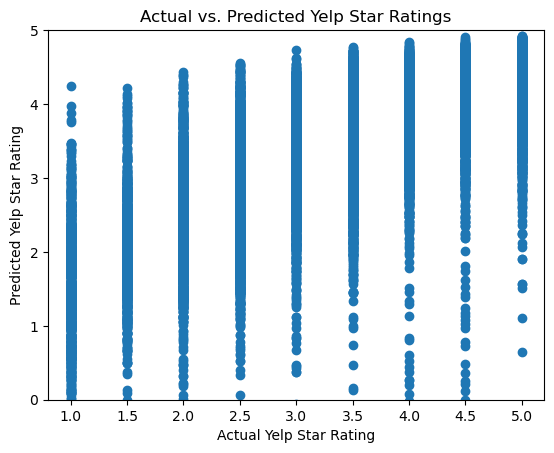

In [24]:
#Create y_predicted variable for y values that are predicted by the test data
y_predicted = reg.predict(X_test)

#Plot predicted y values against actual y values
plt.scatter(y_test, y_predicted)
plt.xlabel("Actual Yelp Star Rating")
plt.ylabel("Predicted Yelp Star Rating")
plt.title("Actual vs. Predicted Yelp Star Ratings")
plt.ylim(0, 5)
plt.show()

## 12. Refine the Model
Looking at our plotted data from Step 11, and our R^2 values from Step 10, our model does a moderate job at predicted Yelp star ratings, but it's not great. So we're going to try to improve it.

This time, instead of using only the 3 columns **average_review_sentiment**, **average_review_age**, and **average_review_length** in our model, we'll use all the columns from our **df_merged** dataframe except **stars**.

In [26]:
# Create new DataFrame with all columns except "stars"
df_new = df_merged[[
    'alcohol?',	
    'good_for_kids', 
    'has_bike_parking', 
    'has_wifi', 'is_open', 
    'latitude', 
    'longitude', 
    'price_range', 
    'review_count',
    'take_reservations',
    'takes_credit_cards',
    'average_review_age',
    'average_review_length',
    'average_review_sentiment',
    'number_funny_votes',
    'number_cool_votes',
    'number_useful_votes',
    'average_caption_length',
    'number_pics',
    'average_tip_length',
    'number_tips',	
    'average_number_friends',	
    'average_days_on_yelp',	
    'average_number_fans',	
    'average_review_count',	
    'average_number_years_elite',	
    'weekday_checkins',	
    'weekend_checkins'
]]

X_train, X_test, y_train, y_test = train_test_split(df_new, rating, test_size = 0.2, random_state = 1)

# Update the linear regression model and train it on the new data
reg = LinearRegression().fit(X_train, y_train)

Now we'll calculate R^2 for our training and test sets using the df_new DataFrame, and we'll compare these values to the previous R^2 values. 

In [28]:
#Calculate R^2 for training data
reg.score(X_train, y_train)

0.6822711520237723

In [29]:
#Calculate R^2 for test data
reg.score(X_test, y_test)

0.6516247490864063

Looks like our R^2 values are slightly higher! So this model is slightly better at predicting Yelp ratings than our previous one. To finish, we'll plot it again and see what it looks like: 

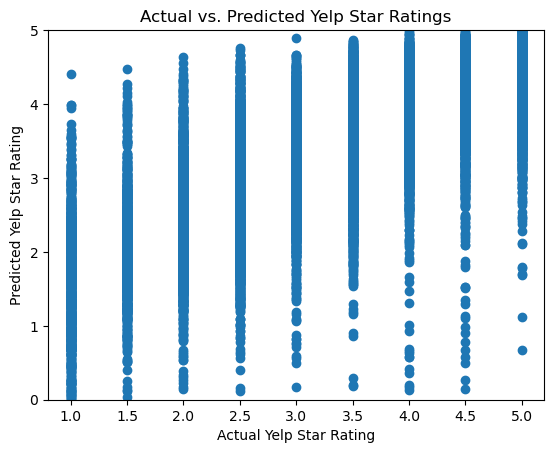

In [31]:
#Create y_predicted variable for y values that are predicted by the test data
y_predicted = reg.predict(X_test)

#Plot predicted y values against actual y values
plt.scatter(y_test, y_predicted)
plt.xlabel("Actual Yelp Star Rating")
plt.ylabel("Predicted Yelp Star Rating")
plt.title("Actual vs. Predicted Yelp Star Ratings")
plt.ylim(0, 5)
plt.show()